# Plots and Results

This notebook generates all plots and figures for the academic report on the Baswana-Sen spanner algorithm.

## ⚠️ Important: Understanding Violation Zones

**Red/Orange regions in these plots** represent results that **contradict the theoretical guarantees** of the Baswana-Sen algorithm:

1. **Stretch Violations (Red regions in Plot 2):** 
   - The Baswana-Sen algorithm guarantees a (2k-1)-spanner, meaning max stretch ≤ (2k-1)
   - Any point above the theoretical line (2k-1) indicates a **violation** of this guarantee
   - Such violations may indicate a bug in the algorithm implementation

2. **Size Anomalies (Orange regions in Plot 1):**
   - While spanner sizes can vary (the algorithm is randomized), values significantly above the theoretical bound O(k·n^(1+1/k)) are suspicious
   - These are marked as warnings but are not necessarily impossible

**Visualizations use Red/Green color scheme to distinguish violations from compliance.**


In [1]:
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path().absolute().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from src.evaluation.metrics import aggregate_results, compute_theoretical_bound

# Set professional aesthetic
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
# Define a color palette that distinguishes 'Safe' (blue/green) from 'Warning' (red/orange)
palette = sns.color_palette("viridis", as_cmap=False)
WARNING_COLOR = "#D62728"  # Red for violations
SUCCESS_COLOR = "#2CA02C"  # Green for compliance
THEORETICAL_COLOR = "#000000" # Black for theoretical lines

# Custom Diverging Colormap for Heatmaps (Red-Yellow-Green, reversed)
cb_diverging = sns.color_palette("RdYlGn_r", as_cmap=True)

matplotlib.rcParams['figure.figsize'] = (12, 8)
matplotlib.rcParams['font.size'] = 12

# Create output directory
output_dir = Path('../results/figures')
output_dir.mkdir(parents=True, exist_ok=True)


## Load results


In [2]:
# Find the most recent results file
data_dir = Path('../data/processed')
results_files = list(data_dir.glob('experiments-results-*.csv'))

if not results_files:
    raise FileNotFoundError(
        f"No experiment results files found in {data_dir.absolute()}\n"
        "Please run experiments first using: python scripts/run_all_experiments.py"
    )

# Sort by modification time (most recent first)
results_files.sort(key=lambda p: p.stat().st_mtime, reverse=True)
results_path = results_files[0]

print(f"Using most recent results file: {results_path.name}")
print(f"File created: {pd.Timestamp.fromtimestamp(results_path.stat().st_mtime)}")
df = pd.read_csv(results_path)
print(f"Loaded {len(df)} experiment results")


Using most recent results file: experiments-results-19-12-2025-14-12-37.csv
File created: 2025-12-19 15:11:25.500128
Loaded 524 experiment results


## Plot 1: Spanner Size vs Theoretical Bound

**Purpose:** Visualize the efficiency gap between empirical spanner sizes and the theoretical bound O(k·n^(1+1/k)).

**Visual Guide:**
- **Green fill** = Empirical size ≤ Theoretical (Good - efficient)
- **Red fill** = Empirical size > Theoretical (Warning - less efficient)
- **Black dashed line** = Theoretical bound


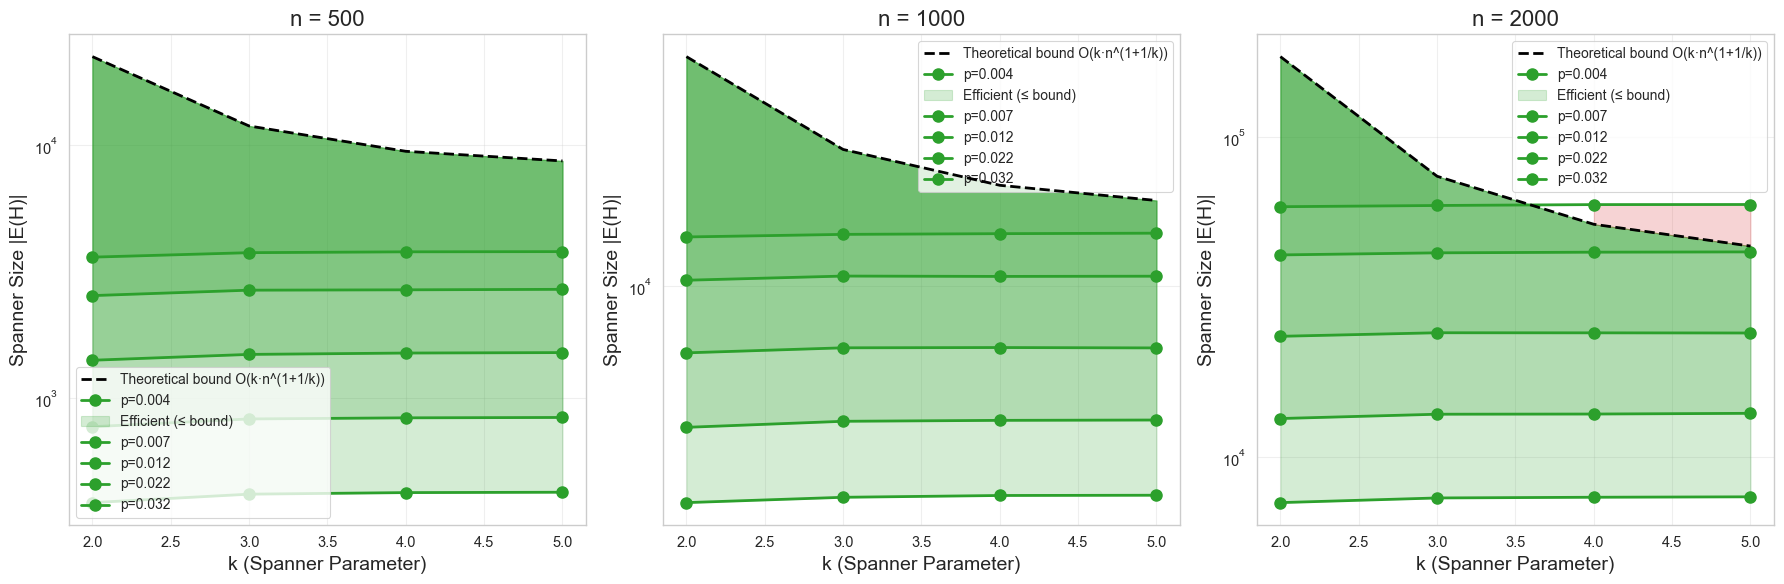

In [ ]:
if not df.empty:
    # Aggregate by (n, p, k)
    df_agg = df.groupby(['n', 'p', 'k'])['spanner_size'].mean().reset_index()
    
    # Get unique n and p values
    n_values = sorted(df_agg['n'].unique())
    p_values = sorted(df_agg['p'].unique())
    
    # Create subplots for different n values
    fig, axes = plt.subplots(1, len(n_values), figsize=(6*len(n_values), 6))
    if len(n_values) == 1:
        axes = [axes]
    
    for idx, n in enumerate(n_values):
        ax = axes[idx]
        df_n = df_agg[df_agg['n'] == n]
        
        # Theoretical bound in Black (dashed) - plot first for legend order
        k_vals = np.array(sorted(df_n['k'].unique()))  # Convert to numpy array for boolean indexing
        theoretical = np.array([compute_theoretical_bound(n, k) for k in k_vals])
        theoretical_line = ax.plot(k_vals, theoretical, color=THEORETICAL_COLOR, linestyle='--', 
                                   linewidth=2, label='Theoretical bound O(k·n^(1+1/k))', zorder=10)
        
        # Get color palette for p values (different from green background)
        p_colors = sns.color_palette("viridis", n_colors=len(p_values[:5]))
        
        # Track fill labels to add only once
        efficient_label_added = False
        above_label_added = False
        
        # Plot empirical data and fill areas - use sorted p values for consistent colors
        sorted_p = sorted(p_values[:5])
        for p_idx, p in enumerate(sorted_p):
            df_np = df_n[df_n['p'] == p].sort_values('k')
            if not df_np.empty and len(df_np) == len(k_vals):
                empirical = df_np['spanner_size'].values
                
                # Plot empirical line with different color for each p
                ax.plot(k_vals, empirical, marker='o', color=p_colors[p_idx], 
                       label=f'p={p:.3f}', linewidth=2, markersize=8, zorder=5)
                
                # Fill between: Green if empirical <= theoretical, Red if above
                below_mask = empirical <= theoretical
                above_mask = empirical > theoretical
                
                if np.any(below_mask):
                    # Good region: Green fill (only label once)
                    ax.fill_between(k_vals[below_mask], empirical[below_mask], 
                                  theoretical[below_mask], color=SUCCESS_COLOR, 
                                  alpha=0.2, label='Efficient (≤ bound)' if not efficient_label_added else '')
                    efficient_label_added = True
                
                if np.any(above_mask):
                    # Warning region: Red fill (only label once)
                    ax.fill_between(k_vals[above_mask], theoretical[above_mask], 
                                  empirical[above_mask], color=WARNING_COLOR, 
                                  alpha=0.2, label='Above bound' if not above_label_added else '')
                    above_label_added = True
        
        ax.set_xlabel('k (Spanner Parameter)', fontsize=14)
        ax.set_ylabel('Spanner Size |E(H)|', fontsize=14)
        ax.set_title(f'n = {n}', fontsize=16)
        
        # Get legend handles and labels, then reorder: theoretical, efficient, above, then p values
        handles, labels = ax.get_legend_handles_labels()
        # Separate into categories
        theoretical_idx = [i for i, l in enumerate(labels) if 'Theoretical' in l]
        efficient_idx = [i for i, l in enumerate(labels) if 'Efficient' in l]
        above_idx = [i for i, l in enumerate(labels) if 'Above' in l]
        p_indices = [i for i, l in enumerate(labels) if l.startswith('p=')]
        
        # Reorder: theoretical, efficient, above, then sorted p values
        new_handles = []
        new_labels = []
        for idx in theoretical_idx:
            new_handles.append(handles[idx])
            new_labels.append(labels[idx])
        for idx in efficient_idx:
            new_handles.append(handles[idx])
            new_labels.append(labels[idx])
        for idx in above_idx:
            new_handles.append(handles[idx])
            new_labels.append(labels[idx])
        # Add p values sorted
        for idx in sorted(p_indices, key=lambda i: float(labels[i].split('=')[1])):
            new_handles.append(handles[idx])
            new_labels.append(labels[idx])
        
        ax.legend(new_handles, new_labels, loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'spanner_size_vs_k.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'spanner_size_vs_k.pdf', bbox_inches='tight')
    plt.show()


## Plot 2: Stretch Analysis with Danger Zone

**Critical Analysis:** This plot identifies violations of the theoretical stretch bound (2k-1).

**Visual Guide:**
- **Red dashed line** = Theoretical maximum stretch (2k-1)
- **Red hatched region** = **Violation Zone** (Impossible region - contradicts Baswana-Sen theorem)
- **Green points** = Actual measured stretch values
- **⚠️ Anomaly markers** = Points that violate the theoretical bound (potential bugs)


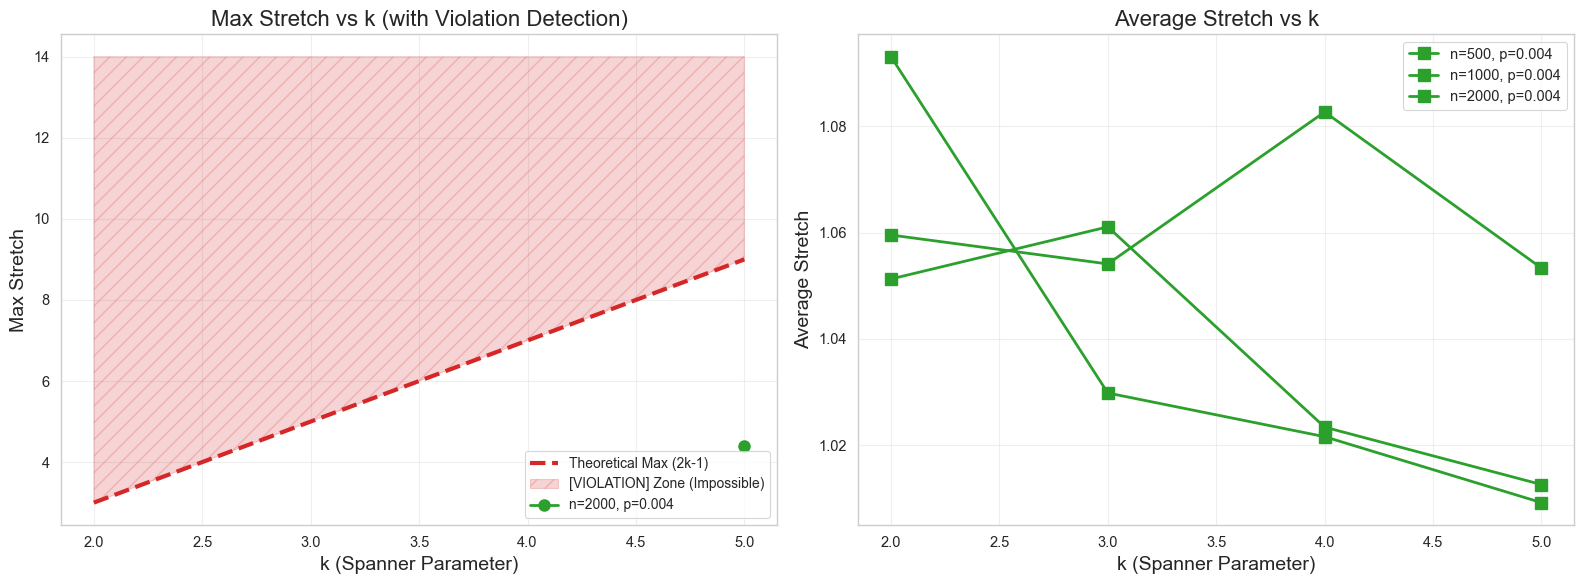

In [ ]:
if not df.empty:
    # Aggregate stretch metrics
    df_stretch = df.groupby(['n', 'p', 'k'])[['max_stretch_edges', 'avg_stretch_edges', 
                                               'max_stretch_pairs', 'avg_stretch_pairs']].mean().reset_index()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Max stretch with danger zone
    ax = axes[0]
    
    # Theoretical bound line: 2k-1 (thick dashed RED/ORANGE for visibility)
    k_range = np.linspace(df_stretch['k'].min(), df_stretch['k'].max(), 100)
    bound_line = 2 * k_range - 1
    
    # Plot Theoretical Limit (thick dashed line)
    ax.plot(k_range, bound_line, color=WARNING_COLOR, linestyle='--', 
           linewidth=3, label='Theoretical Max (2k-1)', zorder=10)
    
    # Shaded Danger Zone with PATTERN (Hatching) - "Impossible Region"
    max_stretch_val = df_stretch['max_stretch_edges'].replace([np.inf, -np.inf], np.nan).max()
    danger_zone_top = max(bound_line.max() + 5, max_stretch_val if not np.isnan(max_stretch_val) else bound_line.max() + 5)
    ax.fill_between(k_range, bound_line, danger_zone_top, 
                   color=WARNING_COLOR, alpha=0.2, hatch='//', 
                   label='[VIOLATION] Zone (Impossible)', zorder=1)
    
    # Plot actual data and detect anomalies
    anomalies_found = []
    # Get color palette for different n values
    n_palette = sns.color_palette("viridis", n_colors=len(df_stretch['n'].unique()))
    
    for n_idx, n in enumerate(sorted(df_stretch['n'].unique())[:3]):  # Limit to 3 n values
        df_n = df_stretch[df_stretch['n'] == n]
        p = df_n['p'].iloc[0]  # Use first p value
        df_np = df_n[df_n['p'] == p].sort_values('k')
        if not df_np.empty:
            # Filter out infinite values for plotting
            df_plot = df_np.copy()
            df_plot['max_stretch_edges'] = df_plot['max_stretch_edges'].replace([np.inf, -np.inf], np.nan)
            
            # Plot normal points with different color for each n
            valid_mask = df_plot['max_stretch_edges'].notna()
            if valid_mask.any():
                ax.plot(df_plot.loc[valid_mask, 'k'], df_plot.loc[valid_mask, 'max_stretch_edges'], 
                       marker='o', color=n_palette[n_idx], label=f'n={n}, p={p:.3f}', 
                       linewidth=2, markersize=8, zorder=5)
            
            # Detect and mark violations
            for _, row in df_plot.iterrows():
                if pd.notna(row['max_stretch_edges']):
                    stretch_limit = 2 * row['k'] - 1
                    if row['max_stretch_edges'] > stretch_limit:
                        # Mark violation with red marker and arrow
                        ax.scatter(row['k'], row['max_stretch_edges'], 
                                 color=WARNING_COLOR, s=200, marker='X', 
                                 zorder=15, edgecolors='black', linewidths=2)
                        # Add annotation
                        ax.annotate('[ANOMALY]', 
                                  xy=(row['k'], row['max_stretch_edges']),
                                  xytext=(row['k'] + 0.2, row['max_stretch_edges'] + 1),
                                  arrowprops=dict(arrowstyle='->', color=WARNING_COLOR, lw=2),
                                  fontsize=10, fontweight='bold', color=WARNING_COLOR,
                                  bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
                        anomalies_found.append((row['k'], row['max_stretch_edges']))
    
    ax.set_xlabel('k (Spanner Parameter)', fontsize=14)
    ax.set_ylabel('Max Stretch', fontsize=14)
    ax.set_title('Max Stretch vs k (with Violation Detection)', fontsize=16)
    if anomalies_found:
        ax.text(0.02, 0.98, f'[WARNING] {len(anomalies_found)} anomalies detected!', 
               transform=ax.transAxes, fontsize=12, fontweight='bold',
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    # Move legend to upper left to avoid covering data points
    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    # Avg stretch
    ax = axes[1]
    # Get color palette for different n values (same as max stretch)
    n_palette_avg = sns.color_palette("viridis", n_colors=len(df_stretch['n'].unique()))
    
    for n_idx, n in enumerate(sorted(df_stretch['n'].unique())[:3]):
        df_n = df_stretch[df_stretch['n'] == n]
        p = df_n['p'].iloc[0]
        df_np = df_n[df_n['p'] == p]
        if not df_np.empty:
            ax.plot(df_np['k'], df_np['avg_stretch_edges'], marker='s', 
                   color=n_palette_avg[n_idx], label=f'n={n}, p={p:.3f}', 
                   linewidth=2, markersize=8)
    
    ax.set_xlabel('k (Spanner Parameter)', fontsize=14)
    ax.set_ylabel('Average Stretch', fontsize=14)
    ax.set_title('Average Stretch vs k', fontsize=16)
    # Move legend to upper left to avoid covering data points
    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'stretch_vs_k.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'stretch_vs_k.pdf', bbox_inches='tight')
    plt.show()
    
    if anomalies_found:
        print(f"\n[WARNING] {len(anomalies_found)} stretch violations detected!")
        print("These results contradict the Baswana-Sen theorem and may indicate a bug.")


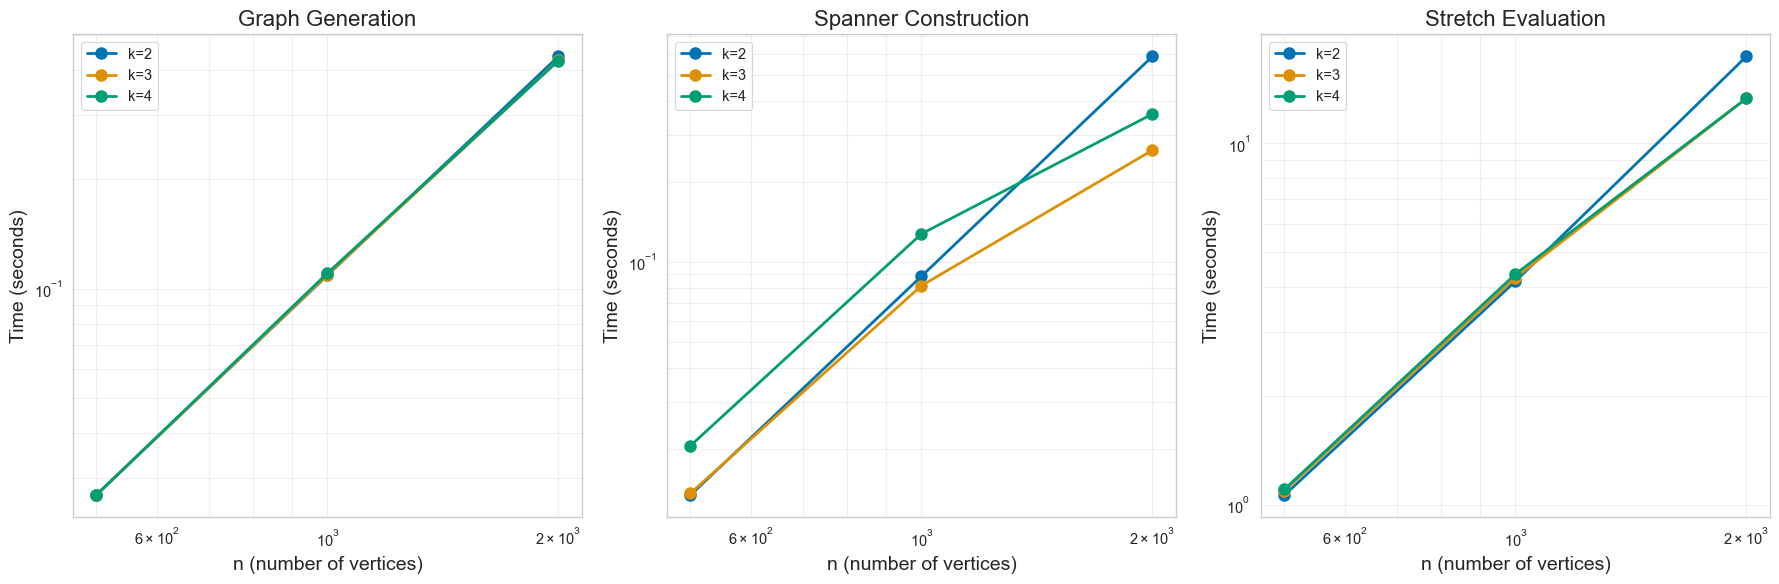

In [ ]:
if not df.empty:
    # Aggregate runtime by n
    df_time = df.groupby(['n', 'k'])[['time_gen', 'time_spanner', 'time_stretch']].mean().reset_index()
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    time_cols = ['time_gen', 'time_spanner', 'time_stretch']
    titles = ['Graph Generation', 'Spanner Construction', 'Stretch Evaluation']
    # Different colors for each component (like user requested)
    component_colors = [SUCCESS_COLOR, WARNING_COLOR, '#FFA500']  # Green, Red, Orange
    
    # Color palette for multiple k values
    k_palette = sns.color_palette("viridis", n_colors=len(df_time['k'].unique()))
    
    for idx, (col, title) in enumerate(zip(time_cols, titles)):
        ax = axes[idx]
        for i, k in enumerate(sorted(df_time['k'].unique())[:3]):  # Limit to 3 k values
            df_k = df_time[df_time['k'] == k]
            # Use component color as base, but vary slightly for different k values
            base_color = component_colors[idx]
            # Blend with k_palette for slight variation
            k_color = k_palette[i] if i < len(k_palette) else base_color
            ax.loglog(df_k['n'], df_k[col], marker='o', label=f'k={k}', 
                     color=k_color, linewidth=2, markersize=8)
        
        ax.set_xlabel('n (number of vertices)', fontsize=14)
        ax.set_ylabel('Time (seconds)', fontsize=14)
        ax.set_title(title, fontsize=16)
        ax.legend()
        ax.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'runtime_vs_n.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'runtime_vs_n.pdf', bbox_inches='tight')
    plt.show()


## Plot 4: Spanner Size Ratio to Theoretical Bound

**Purpose:** Visualize how close empirical spanner sizes are to the theoretical bound O(k·n^(1+1/k)).

**Visual Guide:**
- **Ratio = 1.0** = Exactly matches theoretical bound
- **Ratio < 1.0** = More efficient than theoretical (Good)
- **Ratio > 1.0** = Less efficient than theoretical (Acceptable but not optimal)


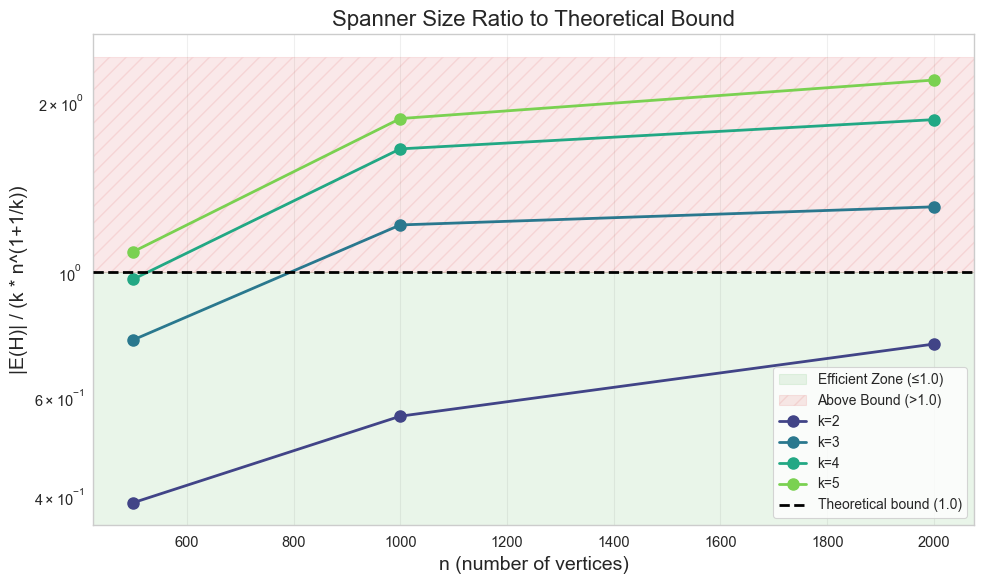

In [6]:
if not df.empty:
    # Plot ratio |E(H)| / (k * n^(1+1/k))
    df_ratio = df.groupby(['n', 'k'])['spanner_size_ratio'].mean().reset_index()
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Use viridis palette for multiple k values
    k_palette = sns.color_palette("viridis", n_colors=len(df_ratio['k'].unique()))
    
    # Background zones
    y_max = df_ratio['spanner_size_ratio'].max() * 1.1
    ax.axhspan(0, 1.0, alpha=0.1, color=SUCCESS_COLOR, label='Efficient Zone (≤1.0)')
    ax.axhspan(1.0, y_max, alpha=0.1, color=WARNING_COLOR, hatch='//', label='Above Bound (>1.0)')
    
    for i, k in enumerate(sorted(df_ratio['k'].unique())):
        df_k = df_ratio[df_ratio['k'] == k].sort_values('n')
        ax.plot(df_k['n'], df_k['spanner_size_ratio'], marker='o', 
               color=k_palette[i] if i < len(k_palette) else SUCCESS_COLOR,
               label=f'k={k}', linewidth=2, markersize=8, zorder=5)
    
    # Reference line at 1.0 (Theoretical bound)
    n_vals = sorted(df_ratio['n'].unique())
    ax.axhline(y=1.0, color=THEORETICAL_COLOR, linestyle='--', linewidth=2, 
              label='Theoretical bound (1.0)', zorder=10)
    
    ax.set_xlabel('n (number of vertices)', fontsize=14)
    ax.set_ylabel('|E(H)| / (k * n^(1+1/k))', fontsize=14)
    ax.set_title('Spanner Size Ratio to Theoretical Bound', fontsize=16)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'spanner_size_ratio.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'spanner_size_ratio.pdf', bbox_inches='tight')
    plt.show()


## Plot 5: Heatmap - Spanner Size Ratio

**Purpose:** Comprehensive overview of spanner efficiency across all parameter combinations.

**Color Guide:**
- **Green** = Low ratio (efficient, close to or below theoretical bound)
- **Yellow** = Values ≈ 1.0 (close to theoretical bound)
- **Red** = High ratio (less efficient, above theoretical bound)
- **Center at 1.0** = Theoretical bound reference

**Interpretation:**
- Values < 1.0 (Green): More efficient than theoretical bound
- Values ≈ 1.0 (Yellow): Close to theoretical bound
- Values > 1.0 (Red): Less efficient, above theoretical bound


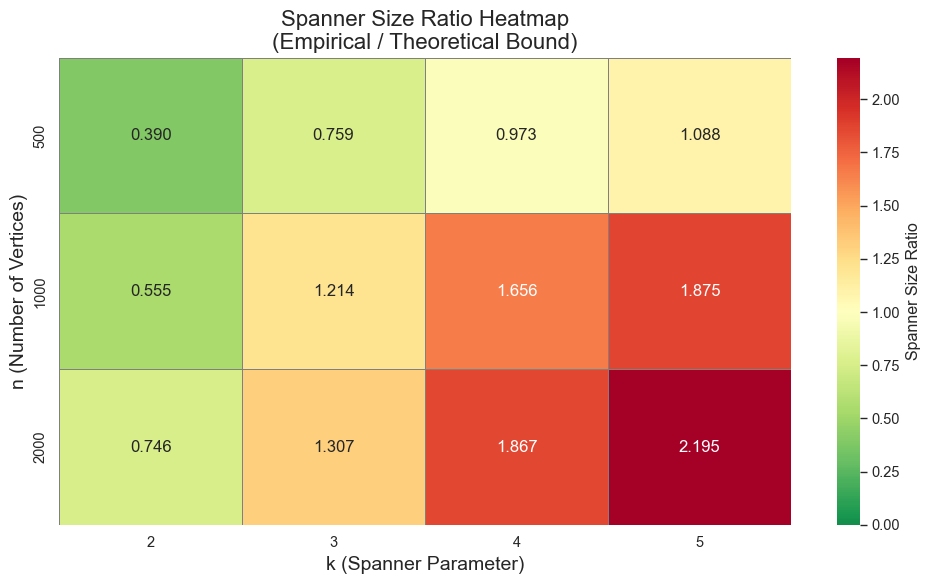


Heatmap Interpretation:
- Values < 1.0 (Green): More efficient than theoretical bound
- Values ≈ 1.0 (Yellow): Close to theoretical bound
- Values > 1.0 (Red): Less efficient, above theoretical bound


In [ ]:
if not df.empty:
    # Create heatmap of spanner size ratio
    df_heatmap = df.groupby(['n', 'k'])['spanner_size_ratio'].mean().reset_index()
    heatmap_pivot = df_heatmap.pivot(index='n', columns='k', values='spanner_size_ratio')
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Use diverging colormap (Red-Yellow-Green, reversed) centered at 1.0
    sns.heatmap(heatmap_pivot, annot=True, fmt='.3f', cmap=cb_diverging, 
               center=1.0, vmin=0, vmax=heatmap_pivot.values.max(),
               cbar_kws={'label': 'Spanner Size Ratio'}, ax=ax,
               linewidths=0.5, linecolor='gray')
    
    ax.set_xlabel('k (Spanner Parameter)', fontsize=14)
    ax.set_ylabel('n (Number of Vertices)', fontsize=14)
    ax.set_title('Spanner Size Ratio Heatmap\n(Empirical / Theoretical Bound)', fontsize=16)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'spanner_size_ratio_heatmap.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'spanner_size_ratio_heatmap.pdf', bbox_inches='tight')
    plt.show()
